# Question 2

In [22]:
# Reading Libraries 
import cv2
import numpy as np 
from matplotlib import pyplot as plt
import pickle
import os

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

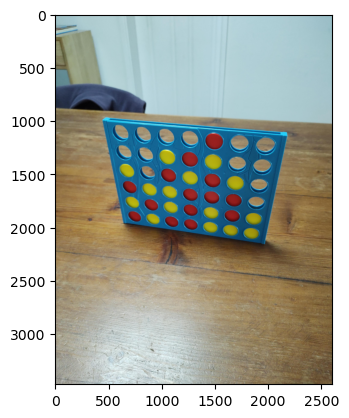

In [23]:
# Read in images 
im_01 = cv2.imread('connect_four_images_A1/004.jpg')
im_01 = cv2.cvtColor(im_01, cv2.COLOR_BGR2RGB)

plt.imshow(im_01)

In [ ]:
# Function to warp the image 

def warp_image(im):

    im_hsv = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)

    pixel_colours = im.reshape((im.shape[0]*im.shape[1], 3))
    norm = colors.Normalize(vmin=-1.0,vmax=1.0)
    norm.autoscale(pixel_colours)
    pixel_colours = norm(pixel_colours).tolist()

    # visualise the colours in a RGB colour space
    H, S, V = cv2.split(im_hsv)

    # define lower and upper ranges of HSV to extract blue board 
    lower_hsv = (75,100,10)
    upper_hsv = (105,255,220)

    # Create mask of pixel inside range of lower and upper colours
    mask = cv2.inRange(im_hsv, lower_hsv, upper_hsv) # (Image, lower_bound, upper_bound)

    # Apply mask to visualise
    im_thresh = im.copy()
    im_thresh[(mask==0),:] = (0,0,0)

    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    im_contours = im.copy()
    cv2.drawContours(im_contours, contours, -1, (0,255,0), 3) # draw using bright green

    arclength = cv2.arcLength(largest_contour, True)
    epsilon = 0.02 * arclength 
    corners = cv2.approxPolyDP(largest_contour, epsilon, True)
    corners = corners.reshape(-1, 2)

    h = 300
    w = 400

    corner_points_output = np.float32([
        [0, 0],
        [w - 1, 0],
        [w - 1, h - 1],
        [0, h - 1]
    ])

    M = cv2.getPerspectiveTransform(np.float32(corners), corner_points_output)
    warped_image = cv2.warpPerspective(im, M, (w,h))


    return warped_image

In [25]:
# Function to determine image state 

def find_game_state(image): 

    # Morphology and contour finding to find corners

    


    # Apply perspective transformation 


    # Read game state using colour thresholding and contour statistics 

    # Initialise array to store game state 
    state = np.zeros((6,7))

    None

    return state

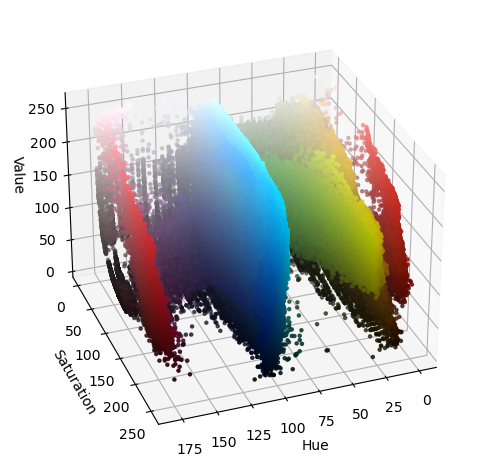

In [26]:


im_01 = cv2.imread('connect_four_images_A1/007.jpg')
im = cv2.cvtColor(im_01, cv2.COLOR_BGR2RGB)

im_hsv = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)

pixel_colours = im.reshape((im.shape[0]*im.shape[1], 3))
norm = colors.Normalize(vmin=-1.0,vmax=1.0)
norm.autoscale(pixel_colours)
pixel_colours = norm(pixel_colours).tolist()

# visualise the colours in a RGB colour space
H, S, V = cv2.split(im_hsv)

fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.scatter(H.flatten(), S.flatten(), V.flatten(), facecolors=pixel_colours, marker='.')
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
axis.view_init(30,70) # (elevation, azimuth, roll): try adjusting to view from different perspectives

plt.tight_layout()



# Apply a colour threshold 

# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
# thresh_im2 = cv2.morphologyEx(thresh_im1, cv2.MORPH_OPEN, kernel)
# thresh_im2 = cv2.morphologyEx(thresh_im2, cv2.MORPH_CLOSE, kernel)

# Calculate contours in the binary image
# contours, hierarchy = cv2.findContours(thresh_im2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# # draw these contours to the image and display the number of extracted contours
# im_temp = thresh_im2.copy()
# im_temp = cv2.cvtColor(im_temp, cv2.COLOR_GRAY2RGB)
# cv2.drawContours(im_temp, contours, -1, (0,255,0), 3) # draw using bright green

# plt.imshow(im_temp, 'gray') # show the thresholded image

# print("Number of contours found: %d"%(len(contours)))

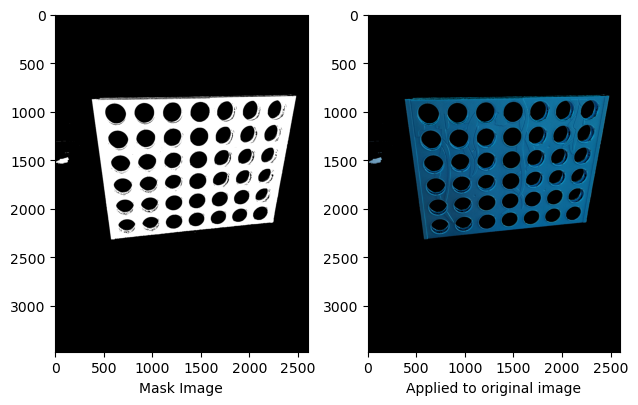

In [27]:
# Define a mask for the blue 

# define lower and upper ranges of HSV to extract blue board 
lower_hsv = (75,100,10)
upper_hsv = (105,255,220)

# Create mask of pixel inside range of lower and upper colours
mask = cv2.inRange(im_hsv, lower_hsv, upper_hsv) # (Image, lower_bound, upper_bound)

# Apply mask to visualise
im_thresh = im.copy()
im_thresh[(mask==0),:] = (0,0,0)
#im_temp = cv2.bitwise_and(im, im, mask=mask) # alternative way

# Display image and mask
plt.subplot(121)
plt.imshow(mask, 'gray')
plt.xlabel('Mask Image')

plt.subplot(122)
plt.imshow(im_thresh)
plt.xlabel('Applied to original image')

plt.tight_layout()

[[[2475  839]]

 [[ 379  875]]

 [[ 576 2312]]

 [[2239 2139]]]


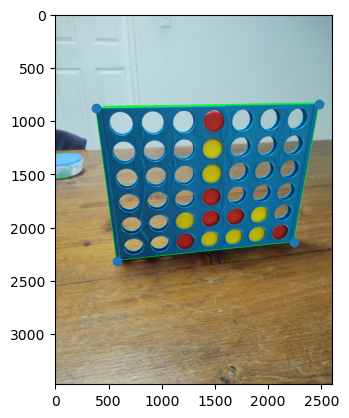

In [28]:
# Apply contour to find edges of the board 
contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
im_contours = im.copy()
cv2.drawContours(im_contours, contours, -1, (0,255,0), 3) # draw using bright green

plt.imshow(im_contours) # show the thresholded image


arclength = cv2.arcLength(largest_contour, True)
epsilon = 0.02 * arclength 
approx_corners = cv2.approxPolyDP(largest_contour, epsilon, True)
print(approx_corners)
approx_corners = approx_corners.reshape(-1, 2)


x = approx_corners[:,0]
y = approx_corners[:,1]

plt.scatter(x, y)

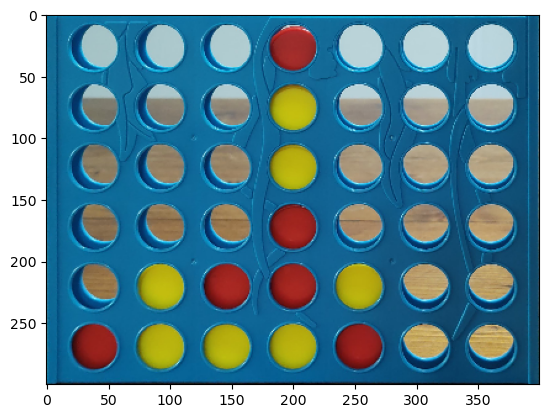

In [29]:
# Apply perspective transformation to the board

h = 300
w = 400

corner_points_output = np.float32([
    [0, 0],
    [w - 1, 0],
    [w - 1, h - 1],
    [0, h - 1]
])

M = cv2.getPerspectiveTransform(np.float32(approx_corners), corner_points_output)
warped_image = cv2.warpPerspective(im, M, (w,h))

plt.imshow(warped_image)


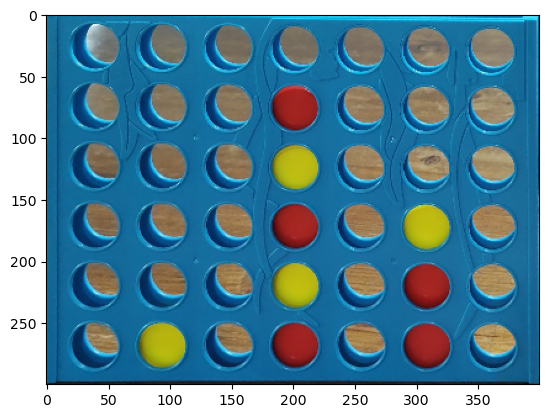

In [33]:
# Finding the game state 

im_01 = cv2.imread('connect_four_images_A1/012.jpg')
im = cv2.cvtColor(im_01, cv2.COLOR_BGR2RGB)

warped_image = warp_image(im)

plt.imshow(warped_image)

# want to find centroids of yellow points and centroids of red points and map that to a position 